## The Shift of Focuses on COVID-19 Research Topics Over Time: Topic Modeling Study
## 1. Introduction
COVID-19 has been the subject of numerous research papers since its outbreak, owing to the disease's rarity. As a result, it's important to keep track of the rising body of evidence in medicine to get a sense of where COVID-19 research is now and to help direct future research.

The goal of this report is to use Latent Dirichlet Allocation (LDA) to extract and summarise the topics found in scientific publication abstracts in this field, as well as to examine how research priorities have shifted over time. This is implemented via Pyspark dataframe and Gensim on 10% of total English articles with well-defined dates since Jul 2019 to speed up the process of data preparation as well as topic modeling.

The dataset used is from CORD-19 that contains all COVID-19 and coronavirus-related academic papers (e.g. SARS, MERS, etc.) from PubMed’s PMC, WHO, bioRxiv, and medRxiv in the form of CSV. The file used in this project is the <code>metadata.csv</code>, and among 19 comma-separated columns, <code>source</code>, <code>title</code>, <code>abstract</code>, <code>publish_time</code>, and <code>authors</code> are selected for the analysis. After dropping rows with Null values, there are 13401 articles with undefined dates, i.e not in the form of <code>yyyy-mm-dd</code>. Besides, this report focuses on English articles published during the period from July 2019 to April 2021, and there are 283693 English articles, which takes account of 96.6% of the publications during this period.



## 2. Preparation
### ** 2.1 Initialization of the cluster:**
** (a) Create the bucket **<br>
<code>REGION=europe-west2
CLUSTERNAME=chenxing-cluster
PROJECT=ST446-project
BUCKET=chenxing-bucket

gsutil mb gs://chenxing-bucket</code>
<br>

** (b) Upload my-actions.sh to the bucket **

<code>gsutil cp my-actions.sh gs://chenxing-bucket</code><br>

** (c) Create the cluster <br> **
<code>gcloud beta dataproc clusters create chenxing-cluster --project st446-project-303018 \
    --bucket chenxing-bucket --region europe-west2 \
    --subnet default --zone europe-west2-a --single-node --master-machine-type n1-standard-4 --master-boot-disk-size 500 \
    --image-version 1.4-debian10 \
    --optional-components=ANACONDA,JUPYTER \
    --enable-component-gateway \
    --initialization-actions \
    gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,gs://chenxing-bucket/my-actions.sh \
    --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy'</code>
    
### 2.2 Download the CORD-19 data
** (a) Download the data from https://www.semanticscholar.org/cord19/download with the following command** <br>
<code> wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2021-03-29.tar.gz </code><br>
<code> tar -xvzf cord-19_2021-04-13.tar.gz </code><br>

This gives the following results:<br>
<code>chenxing_zu1998@chenxing-cluster-m:~$ tar -xvzf cord-19_2021-04-13.tar.gz
2021-04-13/changelog
2021-04-13/cord_19_embeddings.tar.gz
2021-04-13/document_parses.tar.gz
2021-04-13/metadata.csv</code>

** (b) Upload the metadata.csv file to the bucket ** <br>
<code>cd 2021-04-13
 gsutil cp  metadata.csv gs://chenxing-bucket </code>

### 2.3 Load the dataset Pandas dataframe

In [91]:
# import the packages
from pyspark.sql.types import *

filename = 'gs://chenxing-bucket/metadata.csv'

schema = StructType([
    StructField("cord_uid", StringType(), True),
    StructField("sha", StringType(), True),
    StructField("source_x", StringType(), True),
    StructField("title", StringType(), True),
    StructField("doi", StringType(), True),
    StructField("pmcid", StringType(), True),
    StructField("pubmed_id", LongType(), True),
    StructField("license", StringType(), True),
    StructField("abstract", StringType(), True),
    StructField("publish_time", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("journal", StringType(), True),
    StructField("mag_id", IntegerType (), True),
    StructField("who_covidence_id", StringType(), True),
    StructField("arxiv_id", StringType(), True),
    StructField("pdf_json_files", StringType(), True),
    StructField("pmc_json_files", StringType(), True),
    StructField("url", StringType (), True),
    StructField("s2_id", StringType(), True),
])

df = spark.read.csv(filename, header = 'True', schema = schema)

In [92]:
df.show(5)

+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|cord_uid|                 sha|source_x|               title|                 doi|   pmcid|pubmed_id|license|            abstract|publish_time|             authors|       journal|mag_id|who_covidence_id|arxiv_id|      pdf_json_files|      pmc_json_files|                 url|s2_id|
+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|ug7v899j|d1aafb70c066a2068...|     PMC|Clinical features...|10.1186/1471-2334...|PMC35282| 11472636|  no-cc|OBJECTIVE: This r...|  2001-07-04|Madani, Tar

## 3. Data Cleaning
The data cleaning process involves selecting relevant columns, i.e. <code>source</code>, <code>title</code>, <code>abstract</code>, <code>publish_time</code>, and <code>authors</code>, removing rows with <code>Null</code> values and undefined publish time, and sort the articles according to date. The published date is converted to monthly with <code>pyspark.sql.functions.trunc</code> in case there are dates without publications, and during this process, there are 13401 articles without well-defined dates, which return <code>Null</code> with the function mentioned above thus are removed.

In [93]:
# select relevant columns
df = df.select('source_x', 'title', 'abstract', 'publish_time', 'authors')
df.show(5)

+--------+--------------------+--------------------+------------+--------------------+
|source_x|               title|            abstract|publish_time|             authors|
+--------+--------------------+--------------------+------------+--------------------+
|     PMC|Clinical features...|OBJECTIVE: This r...|  2001-07-04|Madani, Tariq A; ...|
|     PMC|Nitric oxide: a p...|Inflammatory dise...|  2000-08-15|Vliet, Albert van...|
|     PMC|Surfactant protei...|Surfactant protei...|  2000-08-25|     Crouch, Erika C|
|     PMC|Role of endotheli...|Endothelin-1 (ET-...|  2001-02-22|Fagan, Karen A; M...|
|     PMC|Gene expression i...|Respiratory syncy...|  2001-05-11|Domachowske, Jose...|
+--------+--------------------+--------------------+------------+--------------------+
only showing top 5 rows



In [4]:
# check null value
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+-----+--------+------------+-------+
|source_x|title|abstract|publish_time|authors|
+--------+-----+--------+------------+-------+
|       0|  254|  144178|         590|  14599|
+--------+-----+--------+------------+-------+



In [94]:
# remove Null values
df = df.na.drop("any")
df.show(5)

+--------+--------------------+--------------------+------------+--------------------+
|source_x|               title|            abstract|publish_time|             authors|
+--------+--------------------+--------------------+------------+--------------------+
|     PMC|Clinical features...|OBJECTIVE: This r...|  2001-07-04|Madani, Tariq A; ...|
|     PMC|Nitric oxide: a p...|Inflammatory dise...|  2000-08-15|Vliet, Albert van...|
|     PMC|Surfactant protei...|Surfactant protei...|  2000-08-25|     Crouch, Erika C|
|     PMC|Role of endotheli...|Endothelin-1 (ET-...|  2001-02-22|Fagan, Karen A; M...|
|     PMC|Gene expression i...|Respiratory syncy...|  2001-05-11|Domachowske, Jose...|
+--------+--------------------+--------------------+------------+--------------------+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import desc
import pyspark.sql.functions as f

df.select('*', f.trunc('publish_time', 'month').alias('month'))\
  .groupby(f.col('month')).count().orderBy(desc('count')).show(5)

+----------+------+
|     month| count|
+----------+------+
|2020-01-01|108631|
|2021-01-01| 43567|
|2020-09-01| 13769|
|      null| 13401|
|2021-03-01| 13089|
+----------+------+
only showing top 5 rows



In [95]:
# number of pulications each month
df = df.select('*', f.trunc('publish_time', 'month').alias('month')).orderBy('month')
new_df = df.na.drop('any') # remove articles with undefined dates

new_df.show(5)

+--------+--------------------+--------------------+------------+--------------------+----------+
|source_x|               title|            abstract|publish_time|             authors|     month|
+--------+--------------------+--------------------+------------+--------------------+----------+
|     PMC|Towards the Absol...|Low Temperature P...|        1952|       WEINTROUB, S.|1952-01-01|
|     PMC|Über eine ungewöh...|Es wird über eine...|        1955|       Ruckes, Josef|1955-01-01|
|     PMC|ACUTE HEPATITIS A...|Observations on t...|  1955-10-31|     Nelson, John B.|1955-10-01|
|     PMC|Die „künstliche N...|Mit der künstlich...|        1956|Günthert, Ernst-A...|1956-01-01|
|     PMC|THE ENHANCING EFF...|Pleuropneumoma-li...|  1957-08-01|     Nelson, John B.|1957-08-01|
+--------+--------------------+--------------------+------------+--------------------+----------+
only showing top 5 rows



## 4. Exploratory Data Analysis

In [8]:
month = new_df.groupby(f.col('month')).count().toPandas() 
month.head()

,month,count
0,1952-01-01,1
1,1955-01-01,1
2,1955-10-01,1
3,1956-01-01,1
4,1957-08-01,1


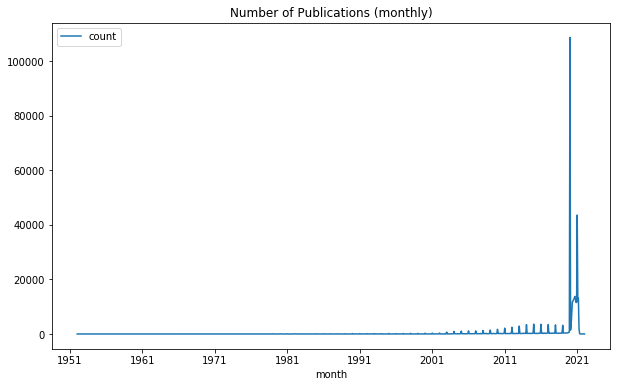

In [10]:
import matplotlib.pyplot as plt

month.plot(x = 'month', y = 'count', figsize = (10, 6), title = 'Number of Publications (monthly)')
plt.show()

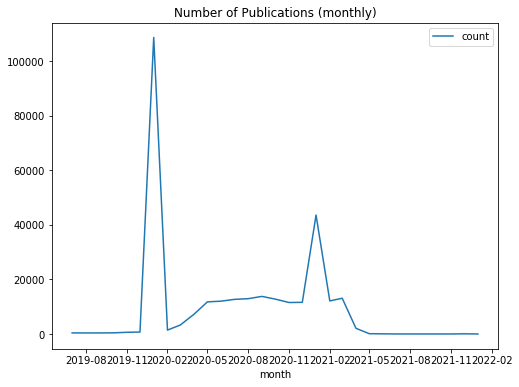

In [11]:
import datetime

month[month['month'] >= datetime.date(2019, 7, 1)]\
     .plot(x = 'month', y = 'count', figsize = (8, 6), title = 'Number of Publications (monthly)')

plt.show()

The majority of COVID-19 and coronavirus-related academic papers (e.g. SARS, MERS, etc.) were published in recent years, especially in 2020 and 2021 since the outbreak of the pandemic as shown in the line graphs above.

In [96]:
import datetime
new_df = new_df.select('*').where(df.month >=  datetime.date(2019, 7, 1)) # select the articles after 1st Sep 2019

In [97]:
# detect the language of articles
from langdetect import detect
from pyspark.sql.functions import udf

lan_det = udf(lambda text: detect(text))
new_df = new_df.withColumn('language', lan_det('title'))
new_df.cache()
new_df.show(5)

+--------+--------------------+--------------------+------------+--------------------+----------+--------+
|source_x|               title|            abstract|publish_time|             authors|     month|language|
+--------+--------------------+--------------------+------------+--------------------+----------+--------+
|     PMC|Development of a ...|BACKGROUND: Exper...|  2019-07-15|Gern, James E; Le...|2019-07-01|      en|
|     PMC|Respiratory syncy...|In the USA and ot...|  2019-07-14|Khawaja, Fareed; ...|2019-07-01|      en|
|     PMC|A novel group of ...|Metagenomics is h...|  2019-07-02|Fernández-Correa,...|2019-07-01|      en|
|     PMC|2HybridTools, a h...|Yeast Two-Hybrid ...|  2019-07-03|Cauchy, Pierre; K...|2019-07-01|      en|
|     PMC|Transcription att...|Ribosome-mediated...|  2019-07-09|Melior, Hendrik; ...|2019-07-01|      en|
+--------+--------------------+--------------------+------------+--------------------+----------+--------+
only showing top 5 rows



In [ ]:
n = new_df.count()
print('Number of articles since Jul 2019: ', n)

Number of articles since Jul 2019:  293682


In [ ]:
lang = new_df.groupBy('language').count().toPandas()
lang = lang.sort_values(by = 'count', ascending = False)
lang.head()

,language,count
0,en,283635
15,es,2915
33,fr,1711
14,de,1544
7,pt,1180


Among all the academic papers published since July 2019, articles published in English take a proportion of 96.9%.  There are also languages used such as French and Spanish.

## 5. Text Preparation for Topic Modelling
### 5.1 Basic Data Preparation
10% of the original English articles, including abstracts and titles, are sampled for topic modelling to speed up LDA.

In [100]:
df1 = new_df.select("*").where("language == 'en'")
df1 = df1.sample(fraction = 0.1, seed = 929) # sample a fraction of the dataset
df_pdseries = df1.select('*').toPandas()
df1.show(5)

+--------+--------------------+--------------------+------------+--------------------+----------+--------+
|source_x|               title|            abstract|publish_time|             authors|     month|language|
+--------+--------------------+--------------------+------------+--------------------+----------+--------+
|     PMC|Discovery of All ...|Interferons orche...|  2019-07-12|Redmond, Anthony ...|2019-07-01|      en|
|     PMC|Mechanism of Cxc ...|BACKGROUND: Acute...|  2019-07-17|Wang, Chang-yong;...|2019-07-01|      en|
|     PMC|Divergent Peptide...|Human leukocyte a...|  2019-07-23|Zhu, Shiyan; Liu,...|2019-07-01|      en|
|     PMC|Immune Responses ...|Infectious laryng...|  2019-07-10|Beltrán, Gabriela...|2019-07-01|      en|
|     PMC|Mannose-Specific ...|To date, a number...|  2019-07-26|Barre, Annick; Si...|2019-07-01|      en|
+--------+--------------------+--------------------+------------+--------------------+----------+--------+
only showing top 5 rows



In [101]:
rd = sc.parallelize(df1.select('abstract', 'title').rdd.map(tuple).collect()) # convert the dataframe to rdd

In [102]:
rd.take(1)

[('Interferons orchestrate host antiviral responses in jawed vertebrates. They are categorized into three classes; IFN1 and IFN3 are the primary antiviral cytokine lineages, while IFN2 responds to a broader variety of pathogens. The evolutionary relationships within and between these three classes have proven difficult to resolve. Here, we reassess interferon evolution, considering key phylogenetic pitfalls including taxon sampling, alignment quality, model adequacy, and outgroup choice. We reveal that cartilaginous fishes, and hence the jawed vertebrate ancestor, possess(ed) orthologs of all three interferon classes. We show that IFN3 groups sister to IFN1, resolve the origins of the human IFN3 lineages, and find that intronless IFN3s emerged at least three times. IFN2 genes are highly conserved, except for IFN-γ-rel, which we confirm resulted from a teleost-specific duplication. Our analyses show that IFN1 phylogeny is highly sensitive to phylogenetic error. By accounting for this, w

In [103]:
rd = rd.flatMap(lambda row: (row[0], row[1])) # combine authors, titles, abstracts

In [104]:
rd = rd.repartition(4)
print('Number of partitions: ', rd.getNumPartitions())

Number of partitions:  4


### 5.2 Parse the data
The texts are further processed to make them amenable to analysis by following steps: 
1. Tokenisation chops text into useful units (words).
2. Lemmatisation groups together inflected words, yields their dictionary form.
3. Remove content specific stop words that appear very frequently in the COVID-19 related corpus with a threshold of 20,000

In [11]:
# import nltk 
# nltk.download('all') 

In [105]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 3]
    return (words)

rdd1 = rd.map(lambda line: (1, get_tokens(line)))
rdd1.take(1)

[(1,
  ['image',
   'text',
   'nucleoside',
   'analogue',
   'among',
   'common',
   'medication',
   'given',
   'treatment',
   'viral',
   'infection',
   'cancer',
   'therapeutic',
   'effectiveness',
   'nucleoside',
   'analogue',
   'dramatically',
   'improved',
   'phosphorylation',
   'protide',
   'approach',
   'developed',
   'using',
   'phosphorylated',
   'nucleoside',
   'masked',
   'esterification',
   'amino',
   'acid',
   'phenol',
   'forming',
   'chiral',
   'phosphorus',
   'center',
   'biological',
   'activity',
   'protides',
   'depends',
   'part',
   'stereochemistry',
   'phosphorus',
   'thus',
   'imperative',
   'efficient',
   'method',
   'developed',
   'chemical',
   'synthesis',
   'isolation',
   'diastereomerically',
   'pure',
   'protides',
   'chiral',
   'protides',
   'often',
   'synthesized',
   'direct',
   'displacement',
   'labile',
   'phenol',
   'pnitrophenol',
   'pentafluorophenol',
   'chiral',
   'phosphoramidate',
   'p

In [106]:
# remove content specific stop words
doc_stop_words = rdd1.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

doc_stop_words = doc_stop_words.filter(lambda a: a[1]>20000).map(lambda r: r[0]).collect()

# throw away stop words
rdd1 = rdd1.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words])) 

rdd1.take(1)[0][1][:10]

['image',
 'text',
 'nucleoside',
 'analogue',
 'among',
 'common',
 'medication',
 'given',
 'treatment',
 'viral']

### 5.3 Convert tokens into a dictionary

In [107]:
# import the packages needed
# ! pip install gensim
# ! pip install pyLDAvis

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
from pprint import pprint

In [108]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

df2 = spark.createDataFrame(rdd1, ["dummy","words"])
df2.cache()
df2.take(1)

[Row(dummy=1, words=['image', 'text', 'nucleoside', 'analogue', 'among', 'common', 'medication', 'given', 'treatment', 'viral', 'infection', 'cancer', 'therapeutic', 'effectiveness', 'nucleoside', 'analogue', 'dramatically', 'improved', 'phosphorylation', 'protide', 'approach', 'developed', 'using', 'phosphorylated', 'nucleoside', 'masked', 'esterification', 'amino', 'acid', 'phenol', 'forming', 'chiral', 'phosphorus', 'center', 'biological', 'activity', 'protides', 'depends', 'part', 'stereochemistry', 'phosphorus', 'thus', 'imperative', 'efficient', 'method', 'developed', 'chemical', 'synthesis', 'isolation', 'diastereomerically', 'pure', 'protides', 'chiral', 'protides', 'often', 'synthesized', 'direct', 'displacement', 'labile', 'phenol', 'pnitrophenol', 'pentafluorophenol', 'chiral', 'phosphoramidate', 'precursor', 'appropriate', 'nucleoside', 'analogue', 'ability', 'produce', 'chiral', 'product', 'dictated', 'synthesis', 'chiral', 'phosphoramidate', 'precursor', 'enzyme', 'phosph

In [109]:
words = list(df2.select('words').toPandas()['words'].values) # extract the tokens from dataframe
words[0]

['image',
 'text',
 'nucleoside',
 'analogue',
 'among',
 'common',
 'medication',
 'given',
 'treatment',
 'viral',
 'infection',
 'cancer',
 'therapeutic',
 'effectiveness',
 'nucleoside',
 'analogue',
 'dramatically',
 'improved',
 'phosphorylation',
 'protide',
 'approach',
 'developed',
 'using',
 'phosphorylated',
 'nucleoside',
 'masked',
 'esterification',
 'amino',
 'acid',
 'phenol',
 'forming',
 'chiral',
 'phosphorus',
 'center',
 'biological',
 'activity',
 'protides',
 'depends',
 'part',
 'stereochemistry',
 'phosphorus',
 'thus',
 'imperative',
 'efficient',
 'method',
 'developed',
 'chemical',
 'synthesis',
 'isolation',
 'diastereomerically',
 'pure',
 'protides',
 'chiral',
 'protides',
 'often',
 'synthesized',
 'direct',
 'displacement',
 'labile',
 'phenol',
 'pnitrophenol',
 'pentafluorophenol',
 'chiral',
 'phosphoramidate',
 'precursor',
 'appropriate',
 'nucleoside',
 'analogue',
 'ability',
 'produce',
 'chiral',
 'product',
 'dictated',
 'synthesis',
 'chir

In [110]:
# Create Dictionary
id2word = corpora.Dictionary(words)

# Create Corpus
texts = words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 6), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 4), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 4), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 4), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 3), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 4), (99, 1), (100, 1)]]


In [111]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('acid', 1),
  ('activity', 1),
  ('amino', 1),
  ('among', 1),
  ('analogue', 3),
  ('approach', 1),
  ('appropriate', 1),
  ('biological', 1),
  ('broad', 1),
  ('cancer', 1),
  ('center', 1),
  ('chemical', 1),
  ('chiral', 6),
  ('combining', 1),
  ('common', 1),
  ('contamination', 1),
  ('depends', 1),
  ('detectable', 1),
  ('developed', 2),
  ('diastereomerically', 1),
  ('diastereometrically', 1),
  ('dictated', 1),
  ('diminuta', 1),
  ('direct', 1),
  ('displacement', 1),
  ('dramatically', 1),
  ('effectiveness', 1),
  ('efficient', 1),
  ('enabled', 1),
  ('enzymatic', 1),
  ('enzyme', 2),
  ('esterification', 1),
  ('evolution', 1),
  ('exhibit', 1),
  ('facilitate', 1),
  ('forming', 1),
  ('given', 1),
  ('high', 1),
  ('hydrolysis', 2),
  ('hydrolyze', 1),
  ('identification', 1),
  ('image', 1),
  ('imperative', 1),
  ('improved', 1),
  ('infection', 1),
  ('isolated', 1),
  ('isolation', 1),
  ('isomer', 4),
  ('labile', 1),
  ('latest', 1),
  ('l

The two major inputs to the LDA topic model are the dictionary(id2word) and the corpus. Each word in the document is assigned a unique id by Gensim. The above-mentioned corpus is a mapping of (word id, word frequency). For example, the (0, 1) indicates that the word id 0 <code>ability</code> appears only once in the first text. Similarly, the word id 5 <code>analogue</code> appears three times, and so on.

## 6. Latent Dirichlet Allocation
Latent Dirichlet Allocation (LDA) is a generative statistical model that allows sets of observations  to be explained by latent groups that explain why some parts of the data are similar (Blei et al 2003). For observations that consist of words collected in a corpus of documents:

  1. Each document is associated with a distribution over topics
  2. Each topic is associated with a multinomial distribution over words
  3. Each word is drawn from a topic distribution

Topic coherence, that scores a single topic by measuring the degree of semantic similarity between high scoring words in the topic, is a useful measurement for determining how effective a topic model is, and it's used to determine the optimum number of topics. Also, perplexity is a metric for determining how accurately a probability model forecasts a sample. A low perplexity value means that the probability distribution is capable of correctly predicting the sample.

In our case, the topic model with 14 topics achieved the highest coherence score (0.574) with a log-perplexity of -9.4.

In [112]:
# define the function to find the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
import random
random.seed(929)

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

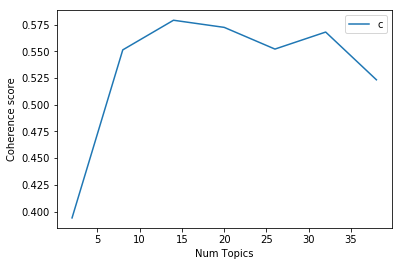

In [ ]:
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.394
Num Topics = 8  has Coherence Value of 0.5513
Num Topics = 14  has Coherence Value of 0.579
Num Topics = 20  has Coherence Value of 0.5723
Num Topics = 26  has Coherence Value of 0.552
Num Topics = 32  has Coherence Value of 0.5679
Num Topics = 38  has Coherence Value of 0.5233


In [119]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.009*"public" + 0.009*"policy" + 0.008*"country" + 0.008*"measure" + '
  '0.007*"impact" + 0.007*"health" + 0.007*"lockdown" + 0.006*"mask" + '
  '0.006*"system" + 0.006*"social"'),
 (1,
  '0.026*"virus" + 0.024*"infection" + 0.020*"coronavirus" + '
  '0.018*"respiratory" + 0.013*"viral" + 0.012*"severe" + 0.011*"human" + '
  '0.010*"syndrome" + 0.009*"acute" + 0.007*"novel"'),
 (2,
  '0.054*"vaccine" + 0.049*"drug" + 0.023*"vaccination" + 0.016*"treatment" + '
  '0.013*"therapeutic" + 0.013*"therapy" + 0.013*"antiviral" + '
  '0.012*"development" + 0.011*"target" + 0.011*"potential"'),
 (3,
  '0.031*"student" + 0.016*"education" + 0.014*"online" + 0.012*"learning" + '
  '0.012*"medical" + 0.012*"school" + 0.012*"training" + 0.011*"program" + '
  '0.010*"telehealth" + 0.009*"experience"'),
 (4,
  '0.028*"cell" + 0.021*"protein" + 0.009*"response" + 0.009*"immune" + '
  '0.009*"expression" + 0.008*"receptor" + 0.008*"gene" + 0.006*"effect" + '
  '0.006*"binding" + 0.006*"analys

The optimal LDA model is built with 14 different topics where each topic is a combination of keywords and each kerwords contributes a certain weightage to the topic. For example, Topic 0 is represented by 

<code> 0.019*"healthcare" + 0.018*"mask" + 0.016*"care" + 0.016*"hospital" + '0.015*"procedure" + 0.013*"infection" + 0.013*"worker" + 0.013*"staff" + 0.012*"surgical" + 0.012*"risk"</code>

means that the top 10 keywords contributing to topic 0 are healthcare, mask, care, etc. and the weight associated with <code>healthcare</code> is 0.019. The weight reflects how important a keyword is in the topic.

In [120]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))


Perplexity:  -9.403353586949764


In [139]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.139867  0.103527       1        1  12.222226
10    -0.020720 -0.230106       2        1  10.996345
13    -0.071285 -0.122674       3        1  10.277855
1     -0.041721  0.013284       4        1  10.208938
0     -0.136263  0.121388       5        1  10.137695
4      0.003960 -0.018268       6        1   8.363482
5     -0.100427  0.022196       7        1   8.250463
7      0.070040 -0.206024       8        1   7.699953
6     -0.049532 -0.063287       9        1   5.433894
12     0.036797 -0.086977      10        1   5.306562
3     -0.050455  0.143654      11        1   3.760523
9      0.061872  0.077210      12        1   3.398504
2      0.031715  0.167167      13        1   3.050239
8      0.405885  0.078910      14        1   0.893319, topic_info=              Term          Freq         Total Category  logprob  loglift
693          model  12126.000000  12126.000000  Default  30.0000  30.0000
1217         child   4761.000000   4761.000000  Default  29.0000  29.0000
392           care  12699.000000  12699.000000  Default  28.0000  28.0000
935        vaccine   5790.000000   5790.000000  Default  27.0000  27.0000
556           cell   7942.000000   7942.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
360         report    185.410935   4137.257176  Topic14  -5.0537   1.6128
2718          aged    141.253872   1043.638370  Topic14  -5.3257   2.7181
301           case    152.416948  14656.801724  Topic14  -5.2496   0.1519
478           year    136.754177   6741.915487  Topic14  -5.3581   0.8201
3143  inflammatory    114.243469   2004.055264  Topic14  -5.5379   1.8534

[1106 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1995      8  0.992879    abdominal
5084      2  0.031739  abnormality
5084      4  0.001511  abnormality
5084      6  0.004534  abnormality
5084      8  0.959730  abnormality
...     ...       ...          ...
6330      9  0.012583        young
6330     10  0.000899        young
6330     14  0.766649        young
6966      4  0.989789     zoonosis
1735      4  0.997893     zoonotic

[4770 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 14, 2, 1, 5, 6, 8, 7, 13, 4, 10, 3, 9])

The interactive plot above is used to examine the produced topics and the associated topics. The larger the bubble on the left-hand side, the more prevalent is the topic. A good topic model should have fairly large, non-overlapping, and scattered bubbles. The bar plot on the right-hand side shows the frequency of keywords associated with the topic selected.

In this case, even though the optimal topic model achieves the highest coherence score(0.58), but the bubbles are mainly located on the left panel with overlapping, which means that it is not a good enough topic model.

## 7. Topic Analysis

In [122]:
articles = df_pdseries['abstract']
title = df_pdseries['title']

In [ ]:
import pandas as pd

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=articles):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=articles)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5083,"cell, protein, response, immune, expression, r...",Interferons orchestrate host antiviral respons...
1,1,4.0,0.5371,"cell, protein, response, immune, expression, r...",BACKGROUND: Acute respiratory distress syndrom...
2,2,12.0,0.5422,"test, sample, antibody, testing, result, posit...",Human leukocyte antigen (HLA) alleles have a h...
3,3,12.0,0.4877,"test, sample, antibody, testing, result, posit...",Infectious laryngotracheitis (ILT) is an acute...
4,4,4.0,0.2655,"cell, protein, response, immune, expression, r...","To date, a number of mannose-specific lectins ..."
5,5,6.0,0.6726,"review, treatment, trial, systematic, evidence...",[Image: see text] Nucleoside analogues are amo...
6,6,10.0,0.5470,"group, mortality, risk, outcome, result, assoc...",The measurement of the optic nerve sheath diam...
7,7,7.0,0.5149,"case, acute, symptom, severe, clinical, infect...",ABSTRACT: Recent advances in analytical techni...
8,8,7.0,0.6263,"case, acute, symptom, severe, clinical, infect...",Ventilator-associated pneumonia (VAP) is one o...
9,9,7.0,0.6674,"case, acute, symptom, severe, clinical, infect...",INTRODUCTION: Some of the most common developm...


In [ ]:
df_pdseries['Topics'] = df_dominant_topic['Dominant_Topic']
df_pdseries['Topic_Perc_Contrib'] = df_dominant_topic['Topic_Perc_Contrib']
df_pdseries.head()

,source_x,title,abstract,publish_time,authors,month,language,Topics,Topic_Perc_Contrib
0,PMC,Discovery of All Three Types in Cartilaginous ...,Interferons orchestrate host antiviral respons...,2019-07-12,"Redmond, Anthony K.; Zou, Jun; Secombes, Chris...",2019-07-01,en,4.0,0.5083
1,PMC,Mechanism of Cxc Chemokine Ligand 5 (CXCL5)/Cx...,BACKGROUND: Acute respiratory distress syndrom...,2019-07-17,"Wang, Chang-yong; Shang, Min; Zhou, Chen-liang...",2019-07-01,en,4.0,0.5371
2,PMC,Divergent Peptide Presentations of HLA-A(*)30 ...,Human leukocyte antigen (HLA) alleles have a h...,2019-07-23,"Zhu, Shiyan; Liu, Kefang; Chai, Yan; Wu, Yanan...",2019-07-01,en,12.0,0.5422
3,PMC,Immune Responses in the Eye-Associated Lymphoi...,Infectious laryngotracheitis (ILT) is an acute...,2019-07-10,"Beltrán, Gabriela; Hurley, David J.; Gogal, Ro...",2019-07-01,en,12.0,0.4877
4,PMC,Mannose-Specific Lectins from Marine Algae: Di...,"To date, a number of mannose-specific lectins ...",2019-07-26,"Barre, Annick; Simplicien, Mathias; Benoist, H...",2019-07-01,en,4.0,0.2655


In [ ]:
df3 = df_pdseries.groupby(by=['Topics', 'month'])['title'].count().reset_index()
df3.head()

,Topics,month,title
0,0.0,2019-07-01,5
1,0.0,2019-08-01,1
2,0.0,2019-10-01,1
3,0.0,2019-11-01,3
4,0.0,2019-12-01,3


In [ ]:
df4 = df_pdseries.groupby(by=['Topics'])['title'].count().reset_index()

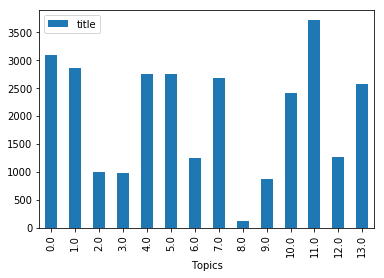

In [ ]:
df4.plot.bar(x = 'Topics', y = 'title')
plt.show()

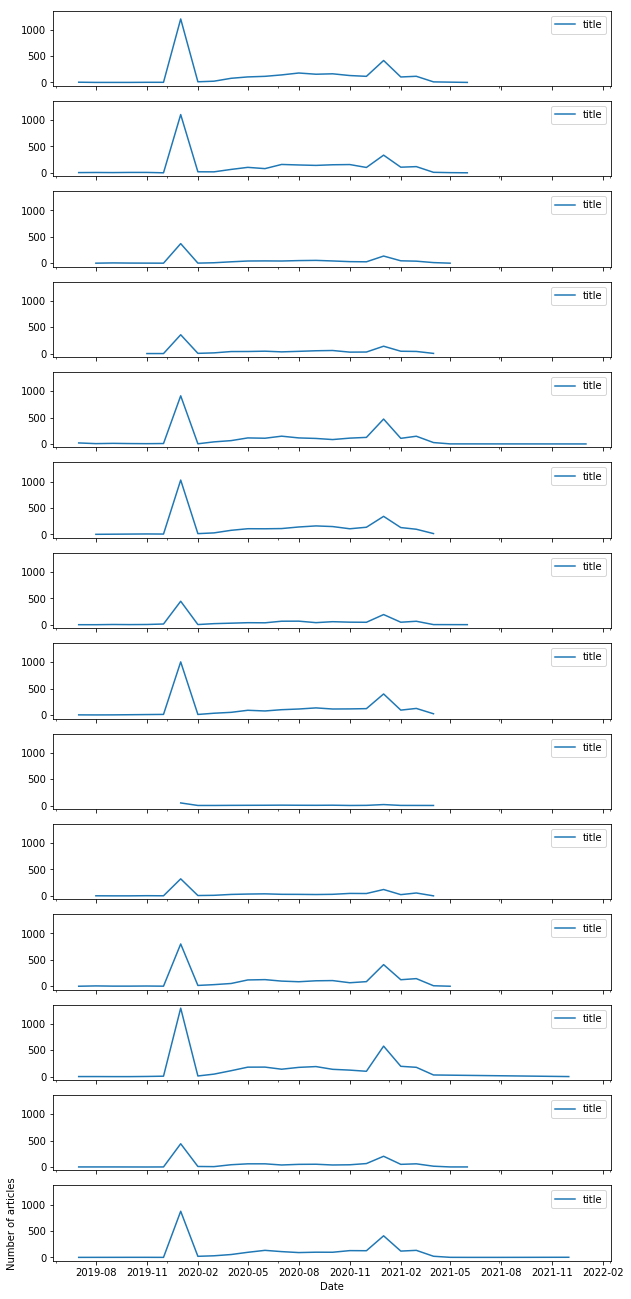

In [159]:
fig, ax = plt.subplots(14, 1, sharex = True, sharey = True, figsize = (10, 23))

df3[df3['Topics'] == 0].plot(x = 'month', y = 'title', ax = ax[0])
df3[df3['Topics'] == 1].plot(x = 'month', y = 'title', ax = ax[1])
df3[df3['Topics'] == 2].plot(x = 'month', y = 'title', ax = ax[2])
df3[df3['Topics'] == 3].plot(x = 'month', y = 'title', ax = ax[3])
df3[df3['Topics'] == 4].plot(x = 'month', y = 'title', ax = ax[4])
df3[df3['Topics'] == 5].plot(x = 'month', y = 'title', ax = ax[5])
df3[df3['Topics'] == 6].plot(x = 'month', y = 'title', ax = ax[6])
df3[df3['Topics'] == 7].plot(x = 'month', y = 'title', ax = ax[7])
df3[df3['Topics'] == 8].plot(x = 'month', y = 'title', ax = ax[8])
df3[df3['Topics'] == 9].plot(x = 'month', y = 'title', ax = ax[9])
df3[df3['Topics'] == 10].plot(x = 'month', y = 'title', ax = ax[10])
df3[df3['Topics'] == 11].plot(x = 'month', y = 'title', ax = ax[11])
df3[df3['Topics'] == 12].plot(x = 'month', y = 'title', ax = ax[12])
df3[df3['Topics'] == 13].plot(x = 'month', y = 'title',  ax = ax[13])

plt.ylabel('Number of articles')
plt.xlabel('Date')

plt.show()

In [190]:
df5 = pd.pivot_table(df3, values = 'title', index = 'month', columns = ['Topics'])
df5 = df5.fillna(0)
res = df5.div(df5.sum(axis=1), axis=0)

res = res.reset_index()

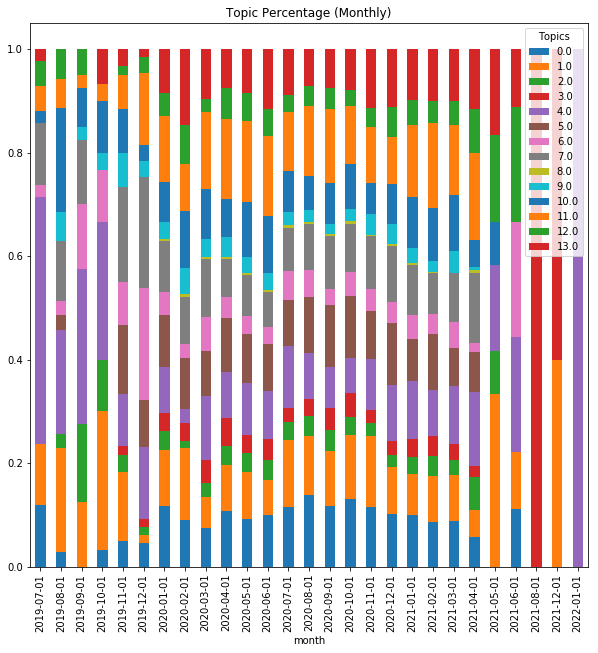

In [196]:
res.plot(
    x = 'month',
    kind = 'bar',
    stacked = True,
    title = 'Topic Percentage (Monthly)',
    mark_right = True, 
    figsize = (10, 10))
plt.show()

The most prevalent topic is topic 11 associated with mental health and behavior, followed by topics 0, 1, 4, 5, 7, 10, and 13. These topics take a significant proportion of the total articles published during this period. Besides, the majority of the topics follow a similar trend with the first peak in Jan 2020 and the second peak in Jan 2021 except topic 8. Also, there are many articles with uncertain publish time, thus are indicated by a date in the future according to allenai/cord19 on Github.

## 8. Conclusion
In conclusion, with 28k articles sampled from the original English corpus with defined dates, the optimal topic model with 14 topics attains the highest coherence score. According to this model, the majority of the topics follow similar trends with slight alterations. For example, the proportions that topics 4 and 6 take decrease with time while topic 1 takes an increasing proportion.

There are some flaws in this project that can be addressed in future research. Firstly, only a fraction of the original English documents are sampled for speedy topic modeling with Gensim. If time allows, we can use Gensim and Pyspark to run LDA on a larger dataset for comparison with log Perplexity, such as taking a larger fraction or translating texts from other languages to English. Furthermore, since the topics obtained using the LDA model are not labeled, we can only draw minimal insights from the study. More research or expertise in the field of COVID-19 is needed for topic labelling. Lastly, sample bias may occur as a result of the sampling process.

## 9. Reference:
1. Topic Modeling in Python with Gensim.(2018) [online] Machine Learning Plus. Available at: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/.
2. Reed, J. (2020). How Natural Language Processing (NLP) Can Help Us Understand the Landscape of COVID-19 Information. [online] Copyright Clearance Center. Available at: http://www.copyright.com/blog/natural-language-processing-information-covid-19/ [Accessed 8 Mar. 2021].
3. Databricks. (2015). Topic modeling with LDA: MLlib meets GraphX. [online] Available at: https://databricks.com/blog/2015/03/25/topic-modeling-with-lda-mllib-meets-graphx.html [Accessed 8 Mar. 2021].
4. Carriere, J., Shafi, H., Brehon, K., Pohar Manhas, K., Churchill, K., Ho, C. and Tavakoli, M. (2021). Case Report: Utilizing AI and NLP to Assist with Healthcare and Rehabilitation During the COVID-19 Pandemic. Frontiers in Artificial Intelligence, [online] 4. Available at: http://www.ece.ualberta.ca/~tbs/pmwiki/pdf/FrontiersAI-Carriere-2021.pdf.
5. Älgå, A., Eriksson, O. and Nordberg, M. (2020). Analysis of Scientific Publications During the Early Phase of the COVID-19 Pandemic: Topic Modeling Study. Journal of Medical Internet Research, 22(11), p.e21559.
6. GitHub. (2021). allenai/cord19. [online] Available at: https://github.com/allenai/cord19 [Accessed 8 Mar. 2021].
7. Ghosh, S. (2018). Topic modelling with Latent Dirichlet Allocation (LDA) in Pyspark. [online] Medium. Available at: https://medium.com/@connectwithghosh/topic-modelling-with-latent-dirichlet-allocation-lda-in-pyspark-2cb3ebd5678e [Accessed 9 Mar. 2021].
8. Kantis, C., Kiernan, S. and Bardi, J.S. (2020). UPDATED: Timeline of the Coronavirus | Think Global Health. [online] Council on Foreign Relations. Available at: https://www.thinkglobalhealth.org/article/updated-timeline-coronavirus.
9. Analytics Vidhya. (2020). PySpark Google Colab | Working With PySpark in Colab. [online] Available at: https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/ [Accessed 22 Apr. 2021].
